# Supervised Learning : Regression
This notebook is the solution for the project under IBM Machine Learning Certificate. The contents of the notebook are listed below:

**Exploration of data set**

1.   Exploratory Data Analytics
     
     a. Data cleaning

     b. Types of features
     *   Numerical features
     *   Categorical features
     
     c. Statistical analysis of Data set

     d. Skewness of numerical features
     
2.   Split the Train test split
**Variations in models**
1. Linear regression model
     *   One-hot encoding
     *   Square root transformation
     *   Standard scaling
     *   Polynomial features
2. Cross validation
     *   K-fold validation

Conclusion


# Import Header files

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline
import io
import sys
from google.colab import files

#Exploration of Dataset
**Name of the dataset**: [Used car Cost estimation Data (Toyota)](https://www.kaggle.com/adityadesai13/used-car-dataset-ford-and-mercedes?select=toyota.csv)

Read data


In [ ]:
uploaded = files.upload()
df2 = pd.read_csv(io.BytesIO(uploaded['toyota.csv']))

Saving toyota.csv to toyota.csv


Size of data set



In [ ]:
df2.shape

(6738, 9)

a. Data Cleaning

Remove duplicate entries and check the size of the data set.

In [ ]:
df2 = df2.drop_duplicates(keep='first').reset_index(drop=True)
df2.shape

(6699, 9)

There are 39 duplicate entries

b.   Types of features



In [ ]:
categorical_features = (df2.dtypes == np.object)
numerical_features = (df2.dtypes == np.float64) | (df2.dtypes == np.int64)

categorical_columns = df2.columns[categorical_features].tolist()
numerical_columns = df2.columns[numerical_features].tolist()

print(f'Categorical Feature columns: {categorical_columns}')
print(f'Numerical Feature columns: {numerical_columns}')

Categorical Feature columns: ['model', 'transmission', 'fuelType']
Numerical Feature columns: ['year', 'price', 'mileage', 'tax', 'mpg', 'engineSize']


c. Statistical Analysis of Data set

***Plot histogram for numerical features***

In [ ]:
def hist_loop(input: pd.DataFrame,
              no_rows: int,
              no_cols: int,
              figure_size: tuple):
    fig, axes = plt.subplots(no_rows,no_cols, figsize=figure_size)
    for i, ax in enumerate(axes.flatten()):
        if i < len(input.columns):
            input[sorted(input.columns)[i]].plot.hist(bins=30, ax=ax)
            ax.set_title(f'{sorted(input.columns)[i]} distribution')
            ax.tick_params(axis='x')
            ax.tick_params(axis='y')
            ax.get_yaxis().get_label().set_visible(False)
        else:
            fig.delaxes(ax=ax)
    fig.tight_layout()

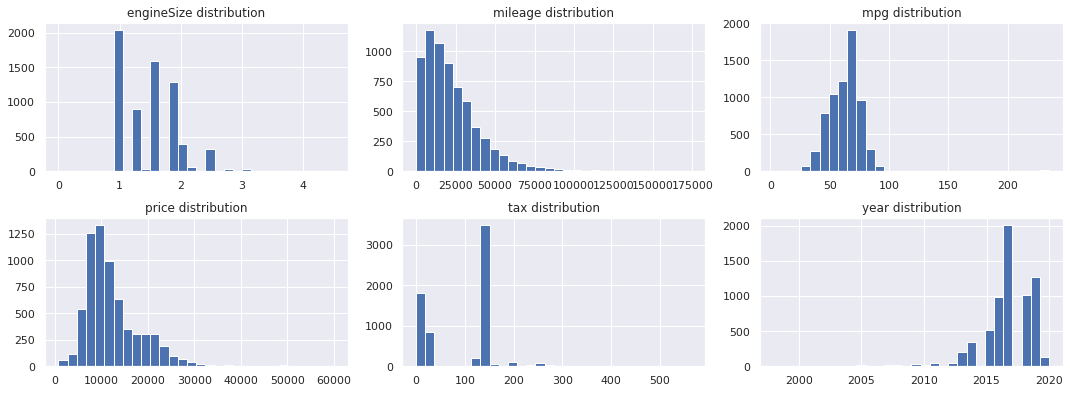

In [ ]:
hist_loop(input=df2[numerical_columns],
          no_rows=3,
          no_cols=3,
          figure_size=(15,8))

d. Plot Skewness of numerical features


In [ ]:
def function_skewness(input: pd.DataFrame, skewness_limit: float) -> pd.DataFrame:
  
    skewness_values = input.skew()
    skewness_columns = (skewness_values
                 .sort_values(ascending=False)
                 .to_frame('Skewness')
                 .query('abs(Skewness) > {}'.format(skewness_limit))
    )
    return skewness_columns
skewness_columns = function_skewness(df2[numerical_columns], 0.75)
skewness_columns

,Skewness
mpg,3.481386
mileage,1.910231
price,1.812441
engineSize,0.834013
year,-2.214188


**Impression**: Except tax distribution, other features are right skewed. In this case, square root transformation can be the best choice for it. Because tax distribution has zero entries.

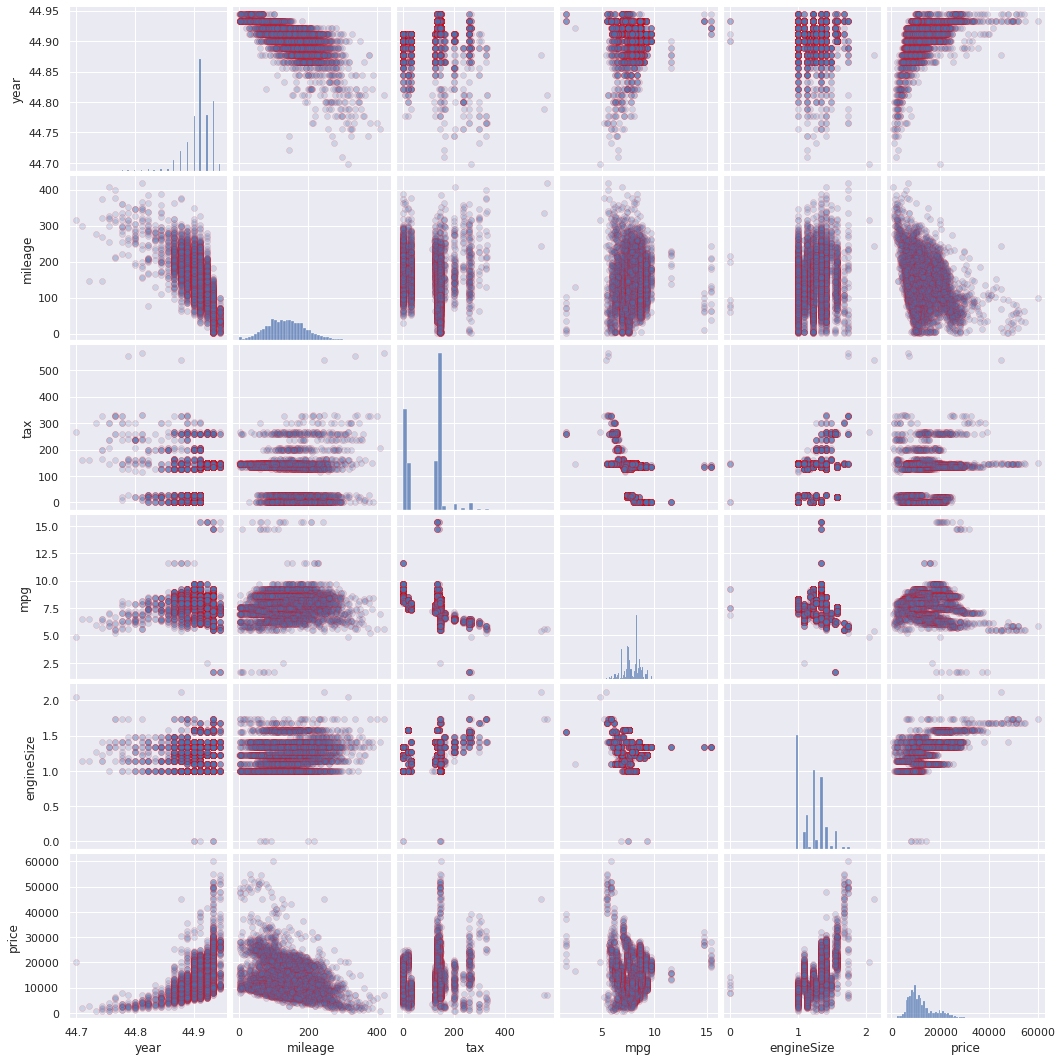

In [ ]:
input_sqrt = df2[numerical_columns].drop('price', axis=1).copy()
for cols in list(skewness_columns.index):
    if cols != 'price':
        input_sqrt[cols] = input_sqrt[cols].apply(np.sqrt)

# Check again
function_skewness(input_sqrt, 0.75)
sns.pairplot(input_sqrt.join(df2['price']), plot_kws=dict(alpha=.2, edgecolor='Red'));

Analysis of categorical features



In [ ]:
df2.describe(include=np.object)

,model,transmission,fuelType
count,6699,6699,6699
unique,18,4,4
top,Yaris,Manual,Petrol
freq,2117,3793,4058


In [ ]:
list(df2['model'].unique())

[' GT86',
 ' Corolla',
 ' RAV4',
 ' Yaris',
 ' Auris',
 ' Aygo',
 ' C-HR',
 ' Prius',
 ' Avensis',
 ' Verso',
 ' Hilux',
 ' PROACE VERSO',
 ' Land Cruiser',
 ' Supra',
 ' Camry',
 ' Verso-S',
 ' IQ',
 ' Urban Cruiser']

In [ ]:
df2['model'] = df2['model'].str.strip(' ')

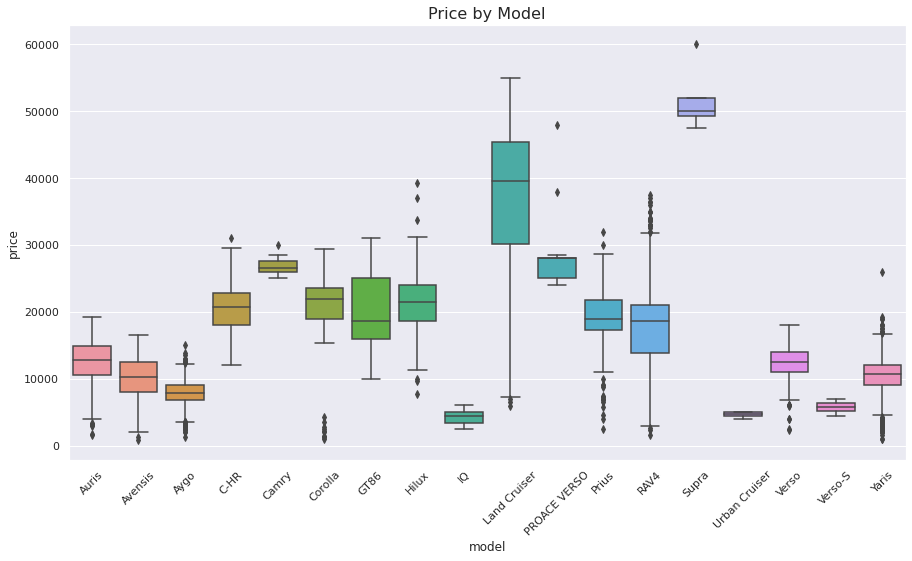

In [ ]:
fig, ax = plt.subplots(figsize=(15,8))
order = sorted(list(df2['model'].unique()))
sns.boxplot(x='model', y='price', data=df2, order=order, ax=ax)
plt.xticks(rotation=45)
plt.title('Price by Model', fontsize=16)
plt.show()

In [ ]:
list(df2['transmission'].unique())

['Manual', 'Automatic', 'Semi-Auto', 'Other']

In [ ]:
list(df2['fuelType'].unique())

['Petrol', 'Other', 'Hybrid', 'Diesel']

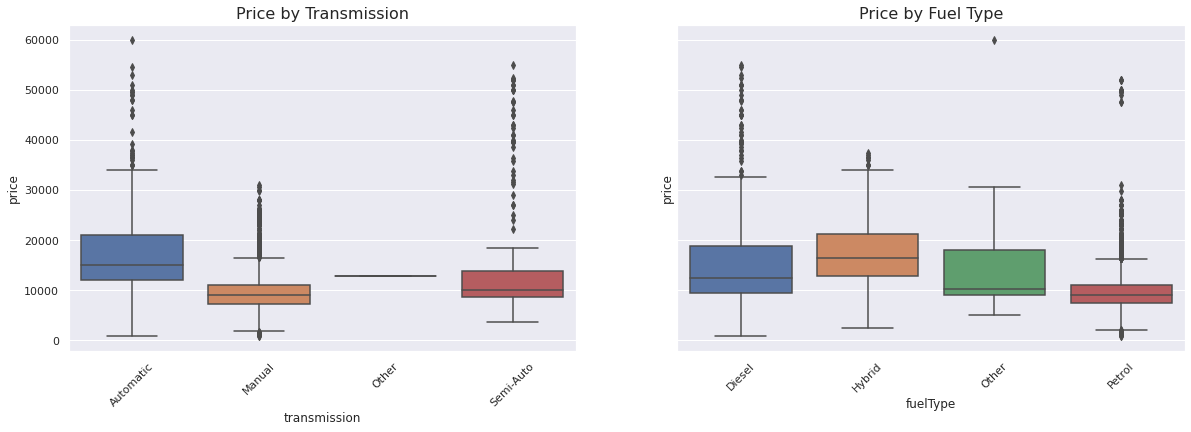

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20,6), sharey=True)
order0 = sorted(list(df2['transmission'].unique()))
sns.boxplot(x='transmission', y='price', data=df2, order=order0, ax=ax[0])
ax[0].set_title('Price by Transmission', fontsize=16)
ax[0].tick_params('x', labelrotation=45)

order1 = sorted(list(df2['fuelType'].unique()))
sns.boxplot(x='fuelType', y='price', data=df2, order=order1, ax=ax[1])
ax[1].set_title('Price by Fuel Type', fontsize=16)
ax[1].tick_params('x', labelrotation=45)
plt.show()

2. Test set split

Take 30% of the data set as test set. 


In [ ]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(df2, test_size=0.3, random_state=0)
print(f'Training set size: {train_set.shape}')
print(f'Test set size: {test_set.shape}')

Training set size: (4689, 9)
Test set size: (2010, 9)


# Model variations



In [ ]:
df = train_set.copy()

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures

In [ ]:
class LR_model:

    # Default values
    target = 'price'
    test_size = 0.25
    random_state = 0
    skew_cols = ['engineSize', 'mileage', 'age']

    def __init__(self, data):
        self.train, self.test = train_test_split(data, test_size=LR_model.test_size, random_state=LR_model.random_state)
    
    def clean_data(self, df):

        """ Cleans the data"""

        df = df[df['year'] <= 2020]
        df['age'] = 2020 - df['year']
        df = df.drop(['year'], axis=1)
        df['model'] = df['model'].str.strip(' ')
        
        return df
        
    def oh_enc(self, X_train, X_test):

        """ Performs one-hot encoding and drops the first category
        """

        ENC = OneHotEncoder(handle_unknown='ignore', sparse=False)

        # Filter categorical features only
        X_train_cat = X_train.select_dtypes(include=['object'])
        X_test_cat = X_test.select_dtypes(include=['object'])

        # Fit one-hot encoding on training set
        # Transform both training set and test set
        X_train_enc = ENC.fit_transform(X_train_cat)
        X_test_enc = ENC.transform(X_test_cat)

        # Join dummy values with numerical features
        X_train_enc_df = pd.DataFrame(X_train_enc,
                                      index=X_train.index,
                                      columns=ENC.get_feature_names(X_train_cat.columns.tolist()))
        X_train = X_train_enc_df.join(X_train.select_dtypes(exclude=['object']))

        # Drop one column of each category
        for col in X_train_cat.columns.tolist():
            cat_cols = X_train.columns[X_train.columns.str.startswith(col)].tolist()
            if len(cat_cols) > 1:
                X_train = X_train.drop(cat_cols[0], axis=1)
        
        # Same steps for the test set
        X_test_enc_df = pd.DataFrame(X_test_enc,
                                     index=X_test.index,
                                     columns=ENC.get_feature_names(X_test_cat.columns.tolist()))
        X_test = X_test_enc_df.join(X_test.select_dtypes(exclude=['object']))
        for col in X_test_cat.columns.tolist():
            cat_cols = X_test.columns[X_test.columns.str.startswith(col)].tolist()
            if len(cat_cols) > 1:
                X_test = X_test.drop(cat_cols[0], axis=1)

        return X_train, X_test

    def sqrt_trans(self, X_train, X_test):

        """ Applies square root transformation for skewed features
        """
        X_train[LR_model.skew_cols] = X_train[LR_model.skew_cols].apply(np.sqrt)
        X_test[LR_model.skew_cols] = X_test[LR_model.skew_cols].apply(np.sqrt)

        return X_train, X_test

    def scale_X(self, X_train, X_test):

        """ Applies standard scaling for all numerical features
        """

        scaler = StandardScaler()

        # Filter numerical features only (excluding binary values)
        float_cols = X_train.columns[~X_train.isin([0,1]).all()].tolist()

        # Fit features in traning set and transform to test set
        X_train[float_cols] = scaler.fit_transform(X_train[float_cols])
        X_test[float_cols] = scaler.transform(X_test[float_cols])

        return X_train, X_test

    def add_pf(self, X_train, X_test, degree=None):

        """ Adds polynomial features into the dataset
        """
        
        PF = PolynomialFeatures(degree=degree, include_bias=False)

        # Filter numerical features only (excluding binary values)
        float_cols = X_train.columns[~X_train.isin([0,1]).all()].tolist()

        # Fit features in traning set and transform to test set
        X_train_pf = PF.fit_transform(X_train[float_cols])
        X_test_pf = PF.transform(X_test[float_cols])
        
        # Add non-numerical features back into the transformed training set
        X_train_pf_df = pd.DataFrame(X_train_pf,
                                     index=X_train.index,
                                     columns=PF.get_feature_names(input_features=float_cols))
        X_train = X_train_pf_df.join(X_train[X_train.columns[~X_train.columns.isin(float_cols)].tolist()])
        
       # Add non-numerical features back into the transformed test set
        X_test_pf_df = pd.DataFrame(X_test_pf,
                                    index=X_test.index,
                                    columns=PF.get_feature_names(input_features=float_cols))
        X_test = X_test_pf_df.join(X_test[X_test.columns[~X_test.columns.isin(float_cols)].tolist()])
        
        return X_train, X_test

    def rmse(self, y_true, y_predicted):

        """ Returns root mean squared error"""
        return np.sqrt(mean_squared_error(y_true, y_predicted))

    def model_fit(self, label=None,
                  encoding=False,
                  squareroot=False,
                  scaling=False,
                  polynomial=False,
                  degree=None):
        
        """ Fits linear regression model and returns 
        RMSE of training set and test set
        """

        # Split data
        train, test = self.clean_data(self.train), self.clean_data(self.test)
        X_train, X_test = train.drop(LR_model.target, axis=1), test.drop(LR_model.target, axis=1)
        y_train, y_test = train[LR_model.target], test[LR_model.target]

        # Perform feature engineering
        if encoding:
            X_train, X_test = self.oh_enc(X_train, X_test)

        if not encoding:
           X_train, X_test = X_train.select_dtypes(exclude=['object']), X_test.select_dtypes(exclude=['object'])

        if squareroot:
            X_train, X_test = self.sqrt_trans(X_train, X_test)

        if scaling:
            X_train, X_test = self.scale_X(X_train, X_test)
        
        if polynomial:
            X_train, X_test = self.add_pf(X_train, X_test, degree)
        
        num_features = X_train.shape[1]
        # Fit model and predict the target
        LR = LinearRegression()
        LR.fit(X_train, y_train)
        y_train_pred = LR.predict(X_train)
        y_test_pred = LR.predict(X_test)
        
        # Compute RMSE and store in a dictionary
        rmse_train = self.rmse(y_train, y_train_pred)
        rmse_test = self.rmse(y_test,  y_test_pred)
        scores = {
            'Model': label,
            'Number of features': num_features,
            'RMSE train': rmse_train,
            'RMSE test': rmse_test
        }
        
        return scores

**One hot encoding**

In [ ]:
error_df = [] # Blank error list to create a data frame later

# Fit non-encoded data
not_enc = LR_model(df).model_fit(label='not encoded')

# Fit encoded data
enc = LR_model(df).model_fit(label='one hot encoded', encoding=True)

# Print out error table
error_df = pd.DataFrame.from_dict([not_enc])
error_df = error_df.append(enc, ignore_index=True)
error_df

,Model,Number of features,RMSE train,RMSE test
0,not encoded,5,3134.414974,3251.084281
1,one hot encoded,28,1700.386931,1960.896246


**Square root transformation**

In [ ]:
not_enc_bc = LR_model(df).model_fit(label='not encoded + squareroot', squareroot=True)

# Fit encoded data
enc_bc = LR_model(df).model_fit(label='one hot encoded + squareroot', encoding=True, squareroot=True)

# Print out error table
error_df = error_df.append([not_enc_bc, enc_bc], ignore_index=True)
error_df

,Model,Number of features,RMSE train,RMSE test
0,not encoded,5,3134.414974,3251.084281
1,one hot encoded,28,1700.386931,1960.896246
2,not encoded + squareroot,5,3277.562670,3342.373357
3,one hot encoded + squareroot,28,1611.152344,1938.144640


**Standard Scaling**

In [ ]:
enc_bc_s = LR_model(df).model_fit(label='one hot encoded + squareroot + scaled', encoding=True, squareroot=True, scaling=True)

# Print out error table
error_df = error_df.append(enc_bc_s, ignore_index=True)
error_df

,Model,Number of features,RMSE train,RMSE test
0,not encoded,5,3134.414974,3251.084281
1,one hot encoded,28,1700.386931,1960.896246
2,not encoded + squareroot,5,3277.562670,3342.373357
3,one hot encoded + squareroot,28,1611.152344,1938.144640
4,one hot encoded + squareroot + scaled,28,1611.152344,1938.144640


**Polynomial Features**

In [ ]:
error_pf_df = pd.DataFrame(columns=['Model', 'Number of features', 'RMSE train', 'RMSE test'])

# Iterate different degree, 1 to 10
for d in list(range(1,11)):
    error = LR_model(df).model_fit(label=f'Degree = {d}', encoding=True, scaling=True, polynomial=True, degree=d)
    error_pf_df = error_pf_df.append(error, ignore_index=True)

# Print out the error table
error_pf_df

,Model,Number of features,RMSE train,RMSE test
0,Degree = 1,28,1700.386931,1.960896e+03
1,Degree = 2,43,1354.675126,1.406153e+03
2,Degree = 3,78,1243.109060,1.407299e+03
3,Degree = 4,148,1157.390710,2.252540e+03
4,Degree = 5,274,1062.560863,2.481287e+04
5,Degree = 6,484,959.156711,4.794091e+05
6,Degree = 7,814,812.838250,5.823222e+06
7,Degree = 8,1309,678.600367,1.349548e+12
8,Degree = 9,2024,648.205364,6.454814e+11
9,Degree = 10,3025,640.225389,1.464881e+13


# Cross-validation and Regularization

In [ ]:
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import make_pipeline
from sklearn_pandas import DataFrameMapper, gen_features

In [ ]:
kf = KFold(shuffle=True, random_state=0, n_splits=5)
df = df[df['year'] <= 2020]
df['age'] = 2020 - df['year']
df = df.drop(['year'], axis=1)
df['model'] = df['model'].str.strip(' ')

X = df.drop('price', axis=1)
y = df['price']

In [ ]:
class XPipe:
    # Skew features observed from the EDA
    skew_cols = ['engineSize', 'mileage', 'age']

    def __init__(self, X):
        self.cat_cols = X.select_dtypes(include=['object']).columns.tolist()
        self.num_cols = X.select_dtypes(exclude=['object']).columns.tolist()
        
    def drop_first(self, cat_values):

        """ Drops one category after one-hot encoding"""

        dummy_df = pd.DataFrame(cat_values)
        dummy_df = dummy_df.drop(0, axis=1)

        return dummy_df.values

    def sqrt_trans(self, num_values):

        """ Applies square root transformation to skewed features"""

        num_df = pd.DataFrame(num_values, columns=self.num_cols)
        num_df[XPipe.skew_cols] = num_df[XPipe.skew_cols].apply(np.sqrt)
        
        return num_df.values

    def model_pipe(self, model, degree=2):

        """ Returns a data pipeline"""

        cat_list = [[col] for col in self.cat_cols]
        cat_features = gen_features(
            columns=cat_list,
            classes=[{'class':OneHotEncoder, 'handle_unknown':'ignore', 'sparse':False},
                     {'class':FunctionTransformer, 'func': self.drop_first}]
        )
        
        mapper = DataFrameMapper((cat_features) + [  
            (self.num_cols, [FunctionTransformer(self.sqrt_trans),
                             StandardScaler(),
                             PolynomialFeatures(degree=degree, include_bias=False)])
        ])

        return make_pipeline(mapper, model)

XPipe(X).model_pipe(LinearRegression())
metrics = {}

In [ ]:
lr_scores = {}

# Iterate over different degrees, 1 to 6
for d in list(range(1,7)):
    score = cross_val_score(XPipe(X)
                            .model_pipe(LinearRegression(), degree=d),
                            X, y, cv=kf, scoring='neg_mean_squared_error')
    lr_scores[f'Degree = {d}'] = np.mean(np.sqrt(-score))

# Create an error table and print it out
lr_rmse = pd.DataFrame.from_dict(lr_scores, orient='index', columns=['Average RMSE']).sort_values('Average RMSE')
lr_rmse

,Average RMSE
Degree = 3,1432.183484
Degree = 2,1443.792111
Degree = 1,1718.408899
Degree = 4,1778.965184
Degree = 5,27755.681679
Degree = 6,180596.605059


In [ ]:
lr_r2_scores = cross_val_score(XPipe(X)
                              .model_pipe(LinearRegression(), degree=3),
                              X, y, cv=kf)
lr_r2_scores

array([0.9630676 , 0.94695759, 0.96153676, 0.92694877, 0.95192922])

In [ ]:
metrics['Average RMSE'] = [lr_rmse['Average RMSE'].values[0]]
metrics['Average R2'] = [np.mean(lr_r2_scores)]

# Lasso Regression

In [ ]:
las_scores = {}

# Iterate over different alphas
for d in [1, 2, 3]:
    for a in [0.005, 0.01, 0.05, 0.1, 0.3, 1, 3, 5, 10]:
        score = cross_val_score(XPipe(X)
                                .model_pipe(Lasso(alpha=a, max_iter=100000), degree=d),
                                X, y, cv=kf, scoring='neg_mean_squared_error')
            
        las_scores[f'Degree = {d}, alpha = {a}'] = np.mean(np.sqrt(-score))

# Create an error table and print it out (first 5 rows)
las_rmse = pd.DataFrame.from_dict(las_scores, orient='index', columns=['Average RMSE']).sort_values('Average RMSE')
las_rmse.head(5)

,Average RMSE
"Degree = 3, alpha = 3",1393.401615
"Degree = 3, alpha = 1",1399.678825
"Degree = 3, alpha = 5",1413.715981
"Degree = 3, alpha = 0.3",1418.124204
"Degree = 3, alpha = 0.1",1427.361948


In [ ]:
las_r2_scores = cross_val_score(XPipe(X)
                                .model_pipe(Lasso(alpha=0.3, max_iter=100000), degree=3),
                                X, y, cv=kf)
las_r2_scores

array([0.96331517, 0.94720766, 0.96139386, 0.93154873, 0.95265881])

In [ ]:
metrics['Average RMSE'].append(las_rmse['Average RMSE'].values[0])
metrics['Average R2'].append(np.mean(las_r2_scores))

# Ridge Regression

In [ ]:
ridge_scores = {}

# Iterate over different alphas
for d in [1, 2, 3]:
    for a in [0.005, 0.01, 0.05, 0.1, 0.3, 1, 3, 5, 10]:
        score = cross_val_score(XPipe(X)
                                .model_pipe(Ridge(alpha=a, max_iter=100000), degree=d),
                                X, y, cv=kf, scoring='neg_mean_squared_error')

                                
        ridge_scores[f'Degree = {d}, alpha = {a}'] = np.mean(np.sqrt(-score))

# Create an error table and print it out (first 5 rows)
ridge_rmse = pd.DataFrame.from_dict(ridge_scores, orient='index', columns=['Average RMSE']).sort_values('Average RMSE')
ridge_rmse.head(5)

,Average RMSE
"Degree = 3, alpha = 1",1398.916770
"Degree = 3, alpha = 0.3",1403.848928
"Degree = 3, alpha = 0.1",1418.622799
"Degree = 3, alpha = 0.05",1424.711608
"Degree = 3, alpha = 3",1426.107998


In [ ]:
ridge_r2_scores = cross_val_score(XPipe(X)
                                  .model_pipe(Ridge(alpha=0.005, max_iter=100000), degree=3),
                                  X, y, cv=kf)
ridge_r2_scores

array([0.96309438, 0.94693861, 0.96153351, 0.92726481, 0.95194661])

In [ ]:
metrics['Average RMSE'].append(ridge_rmse['Average RMSE'].values[0])
metrics['Average R2'].append(np.mean(ridge_r2_scores))

# Elastic Net Regression

In [ ]:
elasticnet_scores = {}

# Iterate over different alphas
for d in [1, 2, 3]:
    for a in [0.005, 0.01, 0.05, 0.1, 0.3, 1, 3, 5, 10]:
        score = cross_val_score(XPipe(X)
                                .model_pipe(ElasticNet(alpha=a, max_iter=100000), degree=d),
                                X, y, cv=kf, scoring='neg_mean_squared_error')
        elasticnet_scores[f'Degree = {d}, alpha = {a}'] = np.mean(np.sqrt(-score))

# Create an error table and print it out (first 5 rows)
elasticnet_rmse = pd.DataFrame.from_dict(elasticnet_scores, orient='index', columns=['Average RMSE']).sort_values('Average RMSE')
elasticnet_rmse.head(5)

,Average RMSE
"Degree = 3, alpha = 0.005",1471.017819
"Degree = 3, alpha = 0.01",1510.381233
"Degree = 2, alpha = 0.005",1583.090097
"Degree = 2, alpha = 0.01",1638.951385
"Degree = 3, alpha = 0.05",1693.665749


In [ ]:
elasticnet_r2_scores = cross_val_score(XPipe(X)
                                       .model_pipe(ElasticNet(alpha=0.005, max_iter=100000), degree=3),
                                       X, y, cv=kf)
elasticnet_r2_scores

array([0.95893972, 0.94234671, 0.95363051, 0.93137833, 0.95321672])

In [ ]:
metrics['Average RMSE'].append(elasticnet_rmse['Average RMSE'].values[0])
metrics['Average R2'].append(np.mean(elasticnet_r2_scores))

# Analysis of metrics

In [ ]:
metrics['Model'] = ['Linear', 'Lasso', 'Ridge', 'Elastic Net']
pd.DataFrame.from_dict(metrics).set_index('Model').sort_values('Average RMSE')

,Average RMSE,Average R2
Model,,
Lasso,1393.401615,0.951225
Ridge,1398.916770,0.950156
Linear,1432.183484,0.950088
Elastic Net,1471.017819,0.947902


#Conclusion

Elastic Net registers the highest RMSE and Lasso model registers the maximum average R2